In [18]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from helpers.ergodic import ErgodicEnsemble

In [41]:
MAX = 20
ENSEMBLES = 2
BIN_RANGE = [2, 5, 10]
OBS_RANGE = [50, 100, 500, 1000, 2000]

CASES = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o),
    "power 4-4.5": lambda i, o: np.random.power(4 if i == 1 else 4.5,o)*MAX,
    "power 2-3": lambda i, o: np.random.power(2 if i == 1 else 3,o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(2 if i == 1 else 2.5,o)*MAX,
    "normal 5-5.2": lambda i, o: np.random.normal(5 if i == 1 else 5.2, 0.5, o),
    "normal 5-5.1": lambda i, o: np.random.normal(5 if i == 1 else 5.1, 0.5, o),
}


def chi(ee):
    ones = np.ones(len(ee.histograms[0]))
    _, p = chisquare(ee.histograms[0]+ones, ee.histograms[1]+ones)
    return p

def gen_data(cases, bin_range, obs_range, trials):
    results = []
    for name, gen in cases.items():
        for b in bin_range:
            for o in obs_range:
                nbsetup.cp(name, b, o)
                for t in range(trials):
                    
                    # generate data
                    observations = []
                    for e in range(ENSEMBLES):
                        observations.append(gen(e, o))
                    
                    # create EE
                    observations = np.array(observations)
                    bins = np.linspace(int(np.floor(observations.min())), int(np.ceil(observations.max())), max(b,3))
                    ee = ErgodicEnsemble(observations=observations, bins=bins)
                    
                    results.append({
                        'bin': b,
                        'obs': o,
                        'dist': name,
                        'c': 1-ee.complexity,
                        'p': chi(ee)
                    })
    return results


In [16]:
df = pd.DataFrame(gen_data(CASES, BIN_RANGE, OBS_RANGE, 1000))
df

normal 5-5.1 10 2000 999


,bin,obs,dist,c,p
0,2,50,power 2,0.993750,2.110937e-01
1,2,50,power 2,0.998185,5.404130e-01
2,2,50,power 2,0.979890,6.627406e-02
3,2,50,power 2,0.993750,2.436281e-01
4,2,50,power 2,0.995724,3.584708e-01
...,...,...,...,...,...
164995,10,2000,normal 5-5.1,0.997789,5.058279e-09
164996,10,2000,normal 5-5.1,0.996037,3.635494e-17
164997,10,2000,normal 5-5.1,0.996692,1.128544e-13
164998,10,2000,normal 5-5.1,0.994583,6.328727e-23


In [30]:
df.to_csv('chisq.csv')

In [86]:
def appnd(dic, key, value):
    try:
        dic[key].append(value)
    except KeyError:
        dic[key] = [value]

{'hot': [4]}

In [95]:
def plot(data, dists=None):
    # setup subplots
    bin_range = data['bin'].unique()
    obs_range = data['obs'].unique()
    if dists == None:
        dists = data['dist'].unique()
    fig, axes = plt.subplots(len(bin_range), len(dists), sharex=True, sharey=True, figsize=(15,10))
    
    # bins per row
    for bi, b in enumerate(bin_range):
        # distributions per column
        for di, d in enumerate(dists):
            # observations on x
            gtemp = []
            for o in obs_range:
                nbsetup.cp(b, d, o)
                filt = data.loc[(data['bin'] == b) & (data['dist'] == d) & (data['obs'] == o)]
                
                # analysis
                analysis = {'obs': o}
                for _, r in filt.iterrows():
                    appnd(analysis, 'p5', 1 if r['p'] > 0.05 else 0)
                    appnd(analysis, 'p1', 1 if r['p'] > 0.01 else 0)
                    
                    c = (1-r['c'])*(o**0.5)
                    appnd(analysis, 'c5a', 1 if c < 0.05 else 0)
                    appnd(analysis, 'c1a', 1 if c < 0.01 else 0)
                    
                    c = c*0.5
                    appnd(analysis, 'c5b', 1 if c < 0.05 else 0)
                    appnd(analysis, 'c1b', 1 if c < 0.01 else 0)
                    
                    #c = c*0.9
                    #appnd(analysis, 'c5c', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1c', 1 if c < 0.01 else 0)
                    
                    #c = (1-r['c'])*0.001
                    #appnd(analysis, 'c5d', 1 if c < 0.05 else 0)
                    #appnd(analysis, 'c1d', 1 if c < 0.01 else 0)
                
                # reset to mean values
                for k, v in analysis.items():
                    if k != 'obs':
                        analysis[k] = sum(analysis[k])/len(analysis[k])
                
                gtemp.append(analysis)
            
            gframe = pd.DataFrame(gtemp)
            # titles
            axes[bi][di].set_title(d)
            axes[bi][di].set(ylim=(-0.1,1.1))
            
            # only show legend on first one
            legend = bi == 0 and di == 0
            sns.lineplot(data=gframe.melt(id_vars='obs'), x="obs", y="value", hue="variable", palette="icefire", ax=axes[bi][di], legend=legend)



10 normal 5-5.1 2000


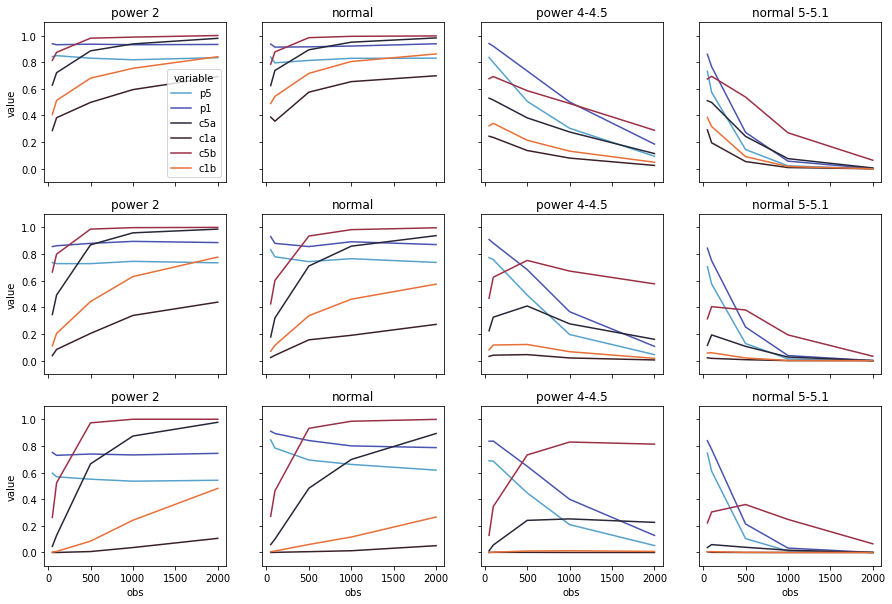

In [96]:
plot(df, ['power 2', 'normal', 'power 4-4.5', 'normal 5-5.1'])

In [83]:
c = 0.05
b = 1 - c
1 - b

0.050000000000000044

In [ ]:
# Standardise 
MAX = 20
ENSEMBLES = 2

def gen_ee(func, obs, binr):
    data = []
    for i in range(ENSEMBLES):
        row = func(i, obs)
        data.append(row)
    data = np.array(data)
    o = max(binr,3)
    bins = np.linspace(int(np.floor(data.min())), int(np.ceil(data.max())), o)
    ee = ErgodicEnsemble(observations=data, bins=bins)
    return ee

In [ ]:



cases = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o),
    "power 4-4.5": lambda i, o: np.random.power(4 if i == 1 else 4.5,o)*MAX,
    "power 2-3": lambda i, o: np.random.power(2 if i == 1 else 3,o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(2 if i == 1 else 2.5,o)*MAX,
    "normal 5-5.2": lambda i, o: np.random.normal(5 if i == 1 else 5.2, 0.5, o),
    "normal 5-5.1": lambda i, o: np.random.normal(5 if i == 1 else 5.1, 0.5, o),
}

lax = {
    #"1": lambda ee: ee.complexity < 0.01,
    #"8": lambda ee: ee.complexity < 0.8/ee.obs_counts[1],
    #"7": lambda ee: ee.complexity < 0.7/ee.obs_counts[1],
    #"9": lambda ee: ee.complexity < 0.9/ee.obs_counts[1],
    #"1": lambda ee: ee.complexity < 1/ee.obs_counts[1],
    #"3": lambda ee: ee.complexity < 0.05/(ee.obs_counts[1]**0.5),
    "0.1*": lambda ee: ee.complexity < 0.1/(ee.obs_counts[1]**0.5),
    "0.05*": lambda ee: ee.complexity < 0.05/(ee.obs_counts[1]**0.5),
    "0.08*": lambda ee: ee.complexity < 0.08/(ee.obs_counts[1]**0.5),
    "0.07*": lambda ee: ee.complexity < 0.07/(ee.obs_counts[1]**0.5),
    "0.01*": lambda ee: ee.complexity < 0.01/(ee.obs_counts[1]**0.25),
    "0.02*": lambda ee: ee.complexity < 0.05/(ee.obs_counts[1]**0.25),
    "0.03*": lambda ee: ee.complexity < 0.1/(ee.obs_counts[1]**0.25),
    #"5": lambda ee: ee.complexity < 0.2/(ee.obs_counts[1]**0.5),
    #"6": lambda ee: ee.complexity < 0.01/(ee.obs_counts[1]**0.25),
}

def analyse_chi(ee):
    lobs = len(ee.histograms[0])
    ones = np.ones(len(ee.histograms[0]))
    _, p = chisquare(ee.histograms[0]+ones, ee.histograms[1]+ones)
    laxness = 0.08/(ee.obs_counts[1]**0.5)
    
    results = [1 if p > 0.05 else 0]
    for lfunc in lax.values():
        results.append(1 if lfunc(ee) else 0)
    return results


def run_mass(binr):
    data = []
    for OBS in [100, 500, 1000, 2000]:
        runs = {}
        for k in cases.keys():
            runs['%s_p' % k] = []
            for l in lax.keys():
                runs['%s_%s' % (k,l)] = []
        
        trials = 1000
        for i in range(trials):
            nbsetup.cp(binr, OBS, i)
            for k, func in cases.items():
                results = analyse_chi(gen_ee(func, OBS, binr))
                runs['%s_p' % k].append(results[0])
                for j, lk in enumerate(lax.keys()):
                    runs['%s_%s' % (k,lk)].append(results[j+1])
        
        app = {"OBS": OBS}
        for k, v in runs.items():
            app[k] = sum(v)/trials
        data.append(app)
    return pd.DataFrame(data)

In [ ]:


bins = [2, 5, 10]
fig, axes = plt.subplots(len(bins), len(cases.keys()), sharex=True, sharey=True, figsize=(15,10))

for d, b in enumerate(bins):
    df = run_mass(b)
    for i, k in enumerate(cases.keys()):
        cols = ['OBS', '%s_p' % k]
        for l in lax.keys():
            cols.append('%s_%s' % (k, l))
        melt = df.loc[:, cols].melt(id_vars="OBS")
        
        axes[d][i].set_title(k)
        axes[d][i].set(ylim=(-0.1,1.1))
        
        legend = i == 0 and d == 0
        sns.lineplot(data=melt, x="OBS", y="value", hue="variable", palette="rainbow", ax=axes[d][i], legend=legend)
